In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
df_main=pd.read_csv('final_df_new.csv')
df_main.head()

,Unnamed: 0,Player,Nation,Pos,Squad,Age,90s,Standard_Gls,Standard_Sh,Standard_SoT,...,Performance_TklW,Performance_PKwon,Performance_PKcon,Performance_OG,Performance_Recov,Aerial Duels_Won,Aerial Duels_Lost,Aerial Duels_Won%,League,Market Value
0,0,William Saliba,FRA,DF,Arsenal,22.0,38.0,2,10,3,...,26,0,1,0,213,72,49,0.595,EPL,80000000.0
1,1,James Tarkowski,ENG,DF,Everton,30.0,38.0,1,25,4,...,42,0,1,0,186,140,61,0.697,EPL,13000000.0
2,2,Joachim Andersen,DEN,DF,Crystal Palace,27.0,37.9,2,21,8,...,35,0,0,0,193,89,46,0.659,EPL,35000000.0
3,3,Florian Lejeune,FRA,DF,Rayo Vallecano,32.0,37.0,3,67,21,...,25,0,0,1,173,80,49,0.620,La Liga,3000000.0
4,4,Dominic Solanke,ENG,FW,Bournemouth,25.0,36.9,19,106,35,...,11,1,0,0,97,97,135,0.418,EPL,45000000.0


In [3]:
df_main.drop(columns=['Unnamed: 0', 'Squad', 'Player'], inplace=True)
df_main.shape

(620, 116)

In [4]:
#One-hot encoding
df_main_encoded = pd.get_dummies(df_main, columns=['Pos', 'League'], dtype='int', drop_first=True)

#df_main_encoded['Nation_ENG'] = (df_main_encoded['Nation'] == 'ENG').astype(int)
df_main_encoded['Nation_SPA'] = (df_main_encoded['Nation'] == 'SPA').astype(int)
df_main_encoded['Nation_Other'] = df_main_encoded.apply(lambda x: 1 if x['Nation'] not in ['ENG', 'SPA'] else 0, axis=1)

df_main_encoded = df_main_encoded.drop(columns=['Nation'])

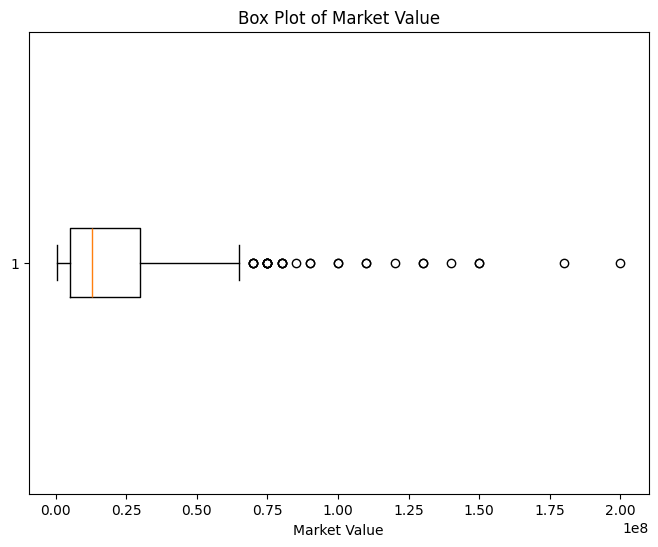

In [7]:
plt.figure(figsize=(8, 6))
plt.boxplot(df_main_encoded['Market Value'], vert=False)
plt.title('Box Plot of Market Value')
plt.xlabel('Market Value')
plt.show()

In [5]:
Q1 = df_main_encoded['Market Value'].quantile(0.25)
Q3 = df_main_encoded['Market Value'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_no_outlier=df_main_encoded[(df_main_encoded['Market Value'] >= lower_bound) & (df_main_encoded['Market Value'] <= upper_bound)]
print(len(df_main_encoded))
print(len(df_no_outlier))

620
590


In [6]:
df_selected=df_main_encoded[['Nation_Other', 'Nation_SPA',
 'Pos_FW','Pos_MF', 'Age', '90s','Standard_Gls', 'Standard_SoT','Standard_SoT/90','Standard_G/SoT', 'Expected_xG','Total_Cmp%','Total_TotDist',
 'Total_PrgDist','SCA_SCA90', 'GCA_GCA90','Tackles_Tkl',
 'Tackles_TklW','Challenges_Tkl%','Blocks_Sh',
 'Blocks_Pass','Clr','Int','Err','Take-Ons_Succ%', 'Take-Ons_Tkld%','Performance_CrdY',
'Performance_CrdR','Performance_Fls','Performance_Fld','Performance_Off','Performance_Recov','Aerial Duels_Won%', 'League_La Liga', 'Market Value']]

In [7]:
df_selected_no_outlier=df_no_outlier[['Nation_Other', 'Nation_SPA',
 'Pos_FW','Pos_MF', 'Age', '90s','Standard_Gls', 'Standard_SoT','Standard_SoT/90','Standard_G/SoT', 'Expected_xG','Total_Cmp%','Total_TotDist',
 'Total_PrgDist','SCA_SCA90', 'GCA_GCA90','Tackles_Tkl',
 'Tackles_TklW','Challenges_Tkl%','Blocks_Sh',
 'Blocks_Pass','Clr','Int','Err','Take-Ons_Succ%', 'Take-Ons_Tkld%','Performance_CrdY',
'Performance_CrdR','Performance_Fls','Performance_Fld','Performance_Off','Performance_Recov','Aerial Duels_Won%', 'League_La Liga', 'Market Value']]

In [8]:
df_main_encoded.name='df_main_encoded'
df_selected.name='df_selected'
df_no_outlier.name='df_no_outlier'
df_selected_no_outlier.name='df_selected_no_outlier'

Main model

In [14]:
X, y = df_main_encoded.loc[:, ~df_main_encoded.columns.isin(['Market Value'])], df_main_encoded['Market Value']
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 123)

X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.25, random_state=123)


#Normalization

train_features_sc = StandardScaler()
train_features_norm = train_features_sc.fit_transform(train_X.to_numpy())
test_features_norm = train_features_sc.transform(test_X.to_numpy())

train_mktval_sc = StandardScaler()
train_mktval_norm = train_mktval_sc.fit_transform(train_y.to_numpy().reshape(-1, 1))
test_mktval_norm = train_mktval_sc.transform(test_y.to_numpy().reshape(-1, 1))

xgb_model = xg.XGBRegressor(seed=123)

#Model fitting
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [1, 3, 5],
    'subsample': [0.3, 0.5, 0.7],
    'n_estimators': [30, 50, 100],
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(train_features_norm, train_mktval_norm.ravel())

best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

xgb_best = xg.XGBRegressor(**best_params)
xgb_best.fit(train_features_norm, train_mktval_norm.ravel())

#Predictions
pred = xgb_best.predict(test_features_norm)
train_pred= xgb_best.predict(train_features_norm)

print("Test RMSE: ", np.sqrt(mean_squared_error(test_mktval_norm, pred)))

print("Train RMSE: ", np.sqrt(mean_squared_error(train_mktval_norm, train_pred)))

print('(Test) R2: ', r2_score(test_mktval_norm, pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.3}
Test RMSE:  0.7865448011869892
Train RMSE:  0.44827767819913394
(Test) R2:  0.5246088589087373


In [10]:
for df in [df_main_encoded, df_selected, df_no_outlier, df_selected_no_outlier]:
  X, y = df.loc[:, ~df.columns.isin(['Market Value'])], df['Market Value']
  train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 123)

  #Normalization
  train_features_sc = StandardScaler()
  train_features_norm = train_features_sc.fit_transform(train_X.to_numpy())
  test_features_norm = train_features_sc.transform(test_X.to_numpy())

  train_mktval_sc = StandardScaler()
  train_mktval_norm = train_mktval_sc.fit_transform(train_y.to_numpy().reshape(-1, 1))
  test_mktval_norm = train_mktval_sc.transform(test_y.to_numpy().reshape(-1, 1))

  #Model fitting
  xgb_model = xg.XGBRegressor(seed=123)

  # Define the hyperparameters grid
  param_grid = {
      'learning_rate': [0.001, 0.01, 0.1],
      'max_depth': [1, 3, 5],
      'subsample': [0.3, 0.5, 0.7],
      'n_estimators': [30, 50, 100]
  }

  grid_search = GridSearchCV(
      estimator=xgb_model,
      param_grid=param_grid,
      scoring='neg_mean_squared_error',
      cv=5,
      verbose=1,
      n_jobs=-1
  )

  grid_search.fit(train_features_norm, train_mktval_norm.ravel())

  best_params = grid_search.best_params_
  print(f"Best hyperparameters for: {df.name}", best_params)

  xgb_best = xg.XGBRegressor(**best_params)
  xgb_best.fit(train_features_norm, train_mktval_norm.ravel())

  pred = xgb_best.predict(test_features_norm)
  train_pred= xgb_best.predict(train_features_norm)

  print(f"Test RMSE for {df.name}: ", np.sqrt(mean_squared_error(test_mktval_norm, pred)))

  print(f"Train RMSE for {df.name}: ", np.sqrt(mean_squared_error(train_mktval_norm, train_pred)))

  print(f'(Test) R2 for {df.name}: ', r2_score(test_mktval_norm, pred))

  print(f'(Train) R2 for {df.name}: ', r2_score(train_mktval_norm, train_pred))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters for: df_main_encoded {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.3}
Test RMSE for df_main_encoded:  0.7865448011869892
Train RMSE for df_main_encoded:  0.44827767819913394
(Test) R2 for df_main_encoded:  0.5246088589087373
(Train) R2 for df_main_encoded:  0.7990471232283938
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters for: df_selected {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
Test RMSE for df_selected:  0.7780166986919599
Train RMSE for df_selected:  0.2676814339601073
(Test) R2 for df_selected:  0.534861817539532
(Train) R2 for df_selected:  0.9283466499130607
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best hyperparameters for: df_no_outlier {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Test RMSE for df_no_outlier:  0.6571725246410878
Train RMSE for df